<a href="https://colab.research.google.com/github/anapitalai/gee/blob/main/Vizuara_Build_your_brain_tumor_AI_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<center><font size=5>Vizuara AI Labs: Build your brain tumor AI model</font></center>**
***


**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a>
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. Building the AI model</a>
- <a href='#cnn'>5. Model evaluation</a>
- <a href='#concl'>6. Testing the model</a>
- <a href='#concl'>7. Conclusion</a>



# Introduction
Welcome to the Vizuara AI Labs project notebook. This guide is designed to help you build your own machine learning model for medical imaging diagnosis, starting with brain tumor detection. The structure of this notebook is organized into modular building blocks, allowing you to easily adapt and apply this workflow to other projects, such as heart disease classification, by modifying specific sections.

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan.

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)


# <a id='intro'>2. Setting up the Environment: Import Statements</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# <a id='intro'>3(a) Data Import</a>

When working on different projects, you will need to load a different dataset. The best way to load a dataset is as follows:

(a) Upload the dataset to Google Drive

(b) The image path will be `/content/drive/My Drive/name_of_your_dataset`

# <a id='intro'>3(b) Data Processing</a>

1. First, we create a data list for storing image data in numpy array form
2. Secondly, we create a paths list for storing paths of all images
3. Thirdly, we create result list for storing one hot encoded form of target class whether normal or tumor

The label 0 is transformed into [1, 0] (one-hot encoding).

The label 1 is transformed into [0, 1] (one-hot encoding).

In [4]:
# This cell updates result list for images with tumor

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') #sparse=False to return a non-sparse matrix
encoder.fit([[0], [1]]) #Fit the encoder to the possible target values

data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/drive/MyDrive/2025/brain_tumor_dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]))

In [5]:
# This cell updates result list for images without tumor

paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/2025/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]))

In [6]:
data = np.array(data)
data.shape

(141, 128, 128, 3)

In [7]:
print(f'Total number of images we have: {len(data)}')

Total number of images we have: 141


In [9]:
result = np.array(result)
result = result.reshape(141,2)

## <a id='intro'>3.1. Splitting the data into training and testing</a>



In [10]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [11]:
print(f'Number of images in training data: {len(x_train)}')

Number of images in training data: 112


In [12]:
print(f'Number of images in testing data: {len(x_test)}')

Number of images in testing data: 29


# <a id='intro'>4. Building the AI model</a>

## <a id='dataset'>4.1. Model Description</a>

In this step, we are constructing an AI model that uses a Convolutional Neural Network (CNN), which is particularly good for image recognition tasks. Our model begins with two convolutional layers that have 32 filters each; these layers are designed to detect basic patterns in the brain MRI images, like edges and textures.

## <a id='dataset'>4.2 Batch normalization</a>


We apply batch normalization after the convolutional layers to accelerate training by scaling the outputs to a standard range.

## <a id='dataset'>4.3 Pooling</a>

Next, we introduce a pooling layer to reduce the dimensionality of the data, which helps the model to focus on the important features, and a dropout layer to prevent overfitting, which is when the model learns the training data too well and performs poorly on new data. We repeat this pattern of convolutional, batch normalization, pooling, and dropout layers with 64 filters in the convolutional layers to capture more complex patterns.

## <a id='dataset'>4.4 Fully connected layer</a>

After processing through these layers, the data is flattened into a one-dimensional array so it can be fed into densely connected layers, which will make the final decisions about what the patterns represent – in our case, whether there is a tumor or not.

## <a id='dataset'>4.5 Activation function and optimizer</a>


The last dense layer uses softmax activation to output probabilities for each class, which completes our model architecture. We compile the model with a categorical crossentropy loss function, which is suitable for multi-class classification problems, and choose the Adamax optimizer, an adaptation of the Adam optimizer that is designed to work well with models that have embeddings and sparse data.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png" alt="CNN Architecture" width="700"/>

>
> *Schematic diagram of a Convolutional Neural Network (CNN): starting with an input image, the network applies multiple convolutional layers to detect features, interspersed with subsampling (pooling) layers to reduce dimensionality, and culminates in fully connected layers that lead to the final output classification*

Source: [Wikipedia](https://en.wikipedia.org)

In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,585,602 (128.12 MB)

 Trainable params: 33,585,410 (128.12 MB)

 Non-trainable params: 192 (768.00 B)

None


In [14]:
y_train.shape

(112, 2)

# <a id='intro'>5. Model evaluation</a>

## <a id='intro'>5.1 What does the training process mean?</a>

This section is the training process of a machine learning model using a Convolutional Neural Network (CNN) architecture in Google Colab. The training is set to run for 30 epochs, which means the model will have 30 complete passes through the entire training dataset. During each epoch, the model learns by adjusting its weights to minimize the difference between its predictions and the actual data.

The batch size is set to 40, indicating that the model will use 40 images at a time to update its weights. The 'verbose' parameter set to 1 enables progress logs to be displayed, showing us the loss (a measure of how far the model's predictions are from the actual labels) and validation loss (the same measure, but calculated using a separate set of data not used in training) after each epoch.

From the output, we can see that as the epochs progress, both the training loss and the validation loss generally decrease, which suggests that the model is learning and improving its predictions on both the training and validation datasets. This output is crucial for monitoring the training process and determining if and when the model is ready for evaluation or deployment.






In [15]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 20.2456 - val_loss: 84.1466
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 15.8709 - val_loss: 40.5305
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 11.4311 - val_loss: 36.1492
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - loss: 5.4111 - val_loss: 23.0667
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 8.8210 - val_loss: 13.6211
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - loss: 2.4632 - val_loss: 15.5306
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 1.1498 - val_loss: 11.7485
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - loss: 2.3365 - val_loss: 5.5424
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.1798 - val_loss: 6.8734
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.5284 - val_loss: 9.4628
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 1.2019 - val_loss: 9.7435
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 1.0223 - val_loss: 8.2328
Epoc

In [16]:

model.save('/content/drive/MyDrive/2025/brain_tumor_model.h5')

In [18]:
import pickle
filename = '/content/drive/MyDrive/2025/braine_tumor_model.pkl'
pickle.dump(model, open(filename, 'wb'))

## <a id='intro'>5.2 Plotting losses</a>

The plot shows the model's loss on the test set and the validation set over the course of training epochs. The 'loss' refers to the value that a machine learning model tries to minimize during training. In this context, 'test loss' typically would refer to the loss calculated on a separate test set that is not used during the training process, whereas 'validation loss' refers to the loss calculated on a validation set, which is used to monitor and tune the model's performance during training.

In the plot shown, after an initial sharp decline, both losses decrease and tend to converge as the epochs increase, which suggests that the model is learning and generalizing well.


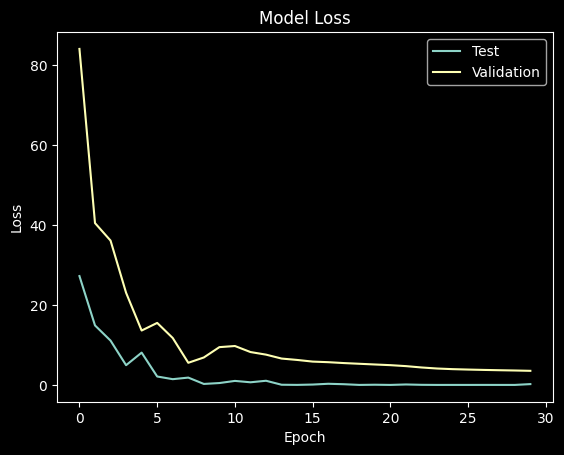

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

# <a id='intro'>6. Testing the model</a>

In the testing phase of our machine learning project, we evaluate the model's performance using new images it hasn't seen before. The code snippet demonstrates how to test the model with an MRI image that has a tumor and one which does not have a tumor.

The process involves loading the image, resizing it to match the input size the model expects, and then reshaping it to the appropriate format for the model to process. The model then predicts whether a tumor is present or not.

The result, displayed below the image, shows the model's confidence level in its prediction. In both cases, we see that the model correctly classifies a "non-tumor" image as "not a tumor" and a "tumor" image as a "tumor" image.

This means that our model is trained successfully now!






In [21]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

100.0% Confidence This Is Its a Tumor


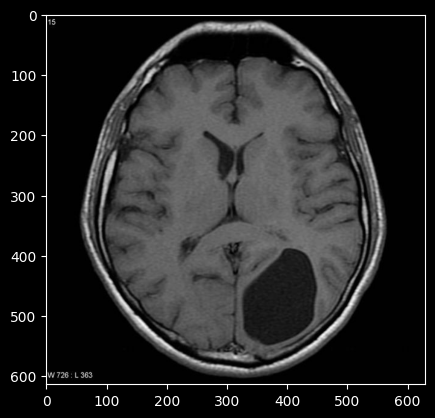

In [22]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/2025/brain_tumor_dataset/no/N11.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

100.0% Confidence This Is A Its a Tumor


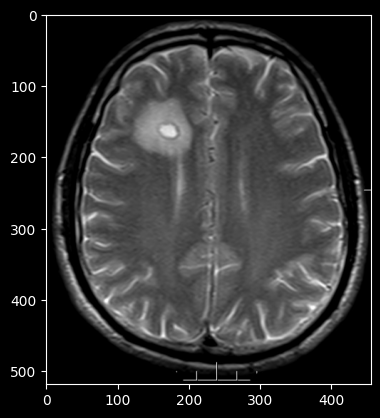

In [24]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/2025/brain_tumor_dataset/yes/Y3.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ' + names(classification))

In [25]:
#@title Provide a title for your app:
heading_title = "Raj brain tumor classification app" # @param {type:"string"}

In [28]:
#@title You can add some example images that you want to be present in your app by default. The user can see use these images to quickly and easily test the model. How many example images do you want to load?
num_examples = 3 # @param {type:"slider", min:1, max:6, step:1}

In [ ]:
#@title Enter the paths for the example images that you want displayed in your app by default. The user can use these images to quickly and easily test the model. Note: You can get the path for the file from the left sidebar. Simply run the code below, select the image file you want to include from its folder, right-click and select 'Copy path'. Then paste the path in the input box displayed:
from matplotlib import pyplot as plt
from PIL import Image

examples=[]
for i in range(num_examples):
  example_path = input(f"example_path_{i+1}:  ")
  examples.append(example_path)

#Displaying the selected images side by side
rows = 1
plt.figure(figsize=(16, 8))
for num, x in enumerate(examples):
    img = Image.open(x)
    plt.subplot(rows,6,num+1)
   # plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)


In [ ]:
#@title You can also add some description and explanation to your app's interace if you want. Go ahead and specify some text for the description and the long description (if you want to):
desc = "Brain tumor app. Let's learn!" # @param {type:"string"}
long_desc = "Select an image or upload one to predict if brain tumor is present or not" # @param {type:"string"}

In [ ]:
import gradio as gr

#@title Select a Theme for Gradio Interface:
theme_selection = "Glass" # @param ["Base", "Default", "Glass", "Monochrome", "Soft"]

theme_dict = {
    "Base": gr.themes.Base(),
    "Default": gr.themes.Default(),
    "Glass": gr.themes.Glass(),
    "Monochrome": gr.themes.Monochrome(),
    "Soft": gr.themes.Soft()
}

# The selected theme is determined by the user's dropdown selection
selected_theme = theme_dict[theme_selection]

# Now you can use the selected_theme variable when you create your Gradio interface

In [ ]:
def recognize_image(image):
    # Resize the image to the expected dimensions
    img = Image.fromarray(image).resize((128, 128))
    # Convert the image to a NumPy array
    x = np.array(img)
    # Reshape the image to match the model input
    x = x.reshape(1, 128, 128, 3)

    # Make a prediction
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]

    # Map the class index to the actual class name (assuming you have a list of class names)
    class_names = ['No Tumor', 'Tumor']  # Example class names, update according to your model
    result = f"{names(classification)}"

    return result


In [ ]:
# Assuming recognize_image, examples, heading_title, desc, long_desc, and selected_theme are defined elsewhere.

# Update the import for components
image = gr.Image()
label = gr.Label()

# Create the interface with the updated component imports
iface = gr.Interface(
    fn=recognize_image,
    inputs=image,
    outputs=label,
    examples=examples,
    title=heading_title,
    description=desc,
    article=long_desc,
    theme=selected_theme  # Make sure this is defined based on user selection as explained in previous messages
)

iface.launch(share=True, debug=True)


# <a id='intro'>7. Conclusions</a>

This notebook has guided you through creating a brain tumor classification model using a Convolutional Neural Network (CNN). We've covered essential steps such as preparing and loading data, designing and training the neural network, and finally testing its ability to classify MRI images accurately.

**The skills and methods you've learned here aren't limited to just identifying brain tumors—they form the foundation for a wide range of image classification projects. You can apply the same techniques to different types of medical imagery, such as detecting signs of heart disease in echocardiograms or identifying various conditions using X-ray images.**

Remember, the principles of loading your dataset, preprocessing the images, building and training the model, and evaluating its performance are similar, no matter what kind of images you're working with. The "building blocks" we've used can be rearranged and adapted to suit any image classification task you're interested in exploring.

So, take what you've learned and start applying it to new challenges—the possibilities for what you can achieve are as broad as your imagination. Whether it's medical imaging or another field entirely, the tools you've mastered here are a solid foundation for your journey in AI and machine learning. Keep learning, keep building, and have fun exploring the vast potential of these technologies!








### Streamlit or Gradio for deployment
### Few lines of code --> vary color scheme